Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "1"


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import datasets

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
import transformers

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# quiet please
torch.set_float32_matmul_precision("medium")
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings(
    "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
)
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType, LoftQConfig, IA3Config


In [4]:
# load my code
%load_ext autoreload
%autoreload 2

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset
from src.models.load import load_model
# from src.prompts.prompt_loading import load_prompt_structure


## Parameters


In [5]:
# params
max_epochs = 1
device = "cuda:0"

cfg = ExtractConfig(
    batch_size=2,
    max_examples=(200, 100),
    intervention_fit_examples=60,
)


## Load model

In [6]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


In [7]:
# TODO I would like to only have biases, but for now lets just try a very small intervention on the last parts of a layer...
peft_config = LoraConfig(
    target_modules=[
        "out_proj",
        "mlp.fc2",
    ],  # only the layers that go directly to the residual
    bias="lora_only",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=1,
    lora_alpha=1,
    lora_dropout=0.0,
)


peft_config = IA3Config(
    task_type=TaskType.SEQ_CLS, target_modules=[ "out_proj",
        "mlp.fc2",], feedforward_modules=["out_proj", "mlp.fc2",]
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 409,600 || all params: 2,780,093,440 || trainable%: 0.014733317740572058


In [8]:
# model.add_adapter(peft_config)
model.print_trainable_parameters()


trainable params: 409,600 || all params: 2,780,093,440 || trainable%: 0.014733317740572058


In [9]:
N = sum(cfg.max_examples)
ds_name = "amazon_polarity"
ds_tokens = load_preproc_dataset(
    ds_name,
    tokenizer,
    N=N,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
).with_format("torch")


2023-12-19 07:46:49.024 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:364 - median token length: 303.5 for amazon_polarity. max_length=777
2023-12-19T07:46:49.024099+0800 INFO median token length: 303.5 for amazon_polarity. max_length=777
2023-12-19 07:46:49.025 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:368 - truncation rate: 0.00% on amazon_polarity
2023-12-19T07:46:49.025533+0800 INFO truncation rate: 0.00% on amazon_polarity
Filter: 100%|██████████| 902/902 [00:00<00:00, 2654.43 examples/s]
2023-12-19 07:46:49.374 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:377 - num_rows (after filtering out truncated rows) 902=>902
2023-12-19T07:46:49.374713+0800 INFO num_rows (after filtering out truncated rows) 902=>902


## Lora train

In [10]:
# from https://github.com/jonkrohn/NLP-with-LLMs/blob/main/code/Finetune-T5-on-GPU.ipynb
from pytorch_optimizer import Ranger21
import lightning.pytorch as pl
from torchmetrics import Metric, MetricCollection, Accuracy, AUROC
from torchmetrics.functional import accuracy


In [11]:
# to_tensor = lambda x: x # torch.from_numpy(x).float()
# to_ds = lambda hs0, hs1, y: TensorDataset(to_tensor(hs0), to_tensor(hs1), to_tensor(y))


class DeceptionDataModule(pl.LightningDataModule):
    def __init__(
        self,
        ds: Dataset,
        batch_size: int = 32,
        #  x_cols = ['input_ids', 'attention_mask', 'label_true', 'label_instructed', 'choice_ids'],
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["ds"])
        self.ds = ds.with_format("torch")
        # self.x_cols = x_cols
        self.setup("train")

    def setup(self, stage: str):
        h = self.hparams

        n = len(self.ds)
        self.splits = {
            "train": (0, int(n * 0.5)),
            "val": (int(n * 0.5), int(n * 0.75)),
            "test": (int(n * 0.75), n),
        }

        self.datasets = {
            key: self.ds.select(range(start, end))
            for key, (start, end) in self.splits.items()
        }

    def create_dataloader(self, ds, shuffle=False):
        return DataLoader(
            ds, batch_size=self.hparams.batch_size, drop_last=False, shuffle=shuffle
        )

    def train_dataloader(self):
        return self.create_dataloader(self.datasets["train"], shuffle=True)

    def val_dataloader(self):
        return self.create_dataloader(self.datasets["val"])

    def test_dataloader(self):
        return self.create_dataloader(self.datasets["test"])


# https://huggingface.co/docs/datasets/use_with_pytorch#data-loading


In [12]:

from einops import rearrange

def get_choice_probs(log_probs, choice_ids):
    c = rearrange(choice_ids, 'b l v -> b (l v)')
    return torch.stack([log_probs[torch.arange(len(c)), c[:, b]] for b in range(c.shape[1])]).T


In [13]:
class LoraFinetuner(pl.LightningModule):
    def __init__(
        self,
        model: AutoModelForCausalLM,
        tokenizer: AutoTokenizer,
        total_steps: int,
        lr=4e-3,
        weight_decay=1e-9,
    ):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.save_hyperparameters(
            ignore=["model", "tokenizer"],
        )

    def forward(self, batch):
        b_in = dict(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )
        b_in = {k: v.to(self.model.device) for k, v in b_in.items()}

        return self.model(
            **b_in, use_cache=False, output_hidden_states=True, return_dict=True
        )
        # odict_keys(['logits', 'hidden_states', 'attentions'])

    def _step(self, batch, batch_idx=0, stage="train"):
        with torch.no_grad():
            with self.model.disable_adapter():
                out = self(batch)
                log_probs = torch.log_softmax(
                    out["logits"][:,-1,],
                    -1)
                # del out

        # self.model.enable_adapters()
        out2 = self(batch)
        log_probs_a = torch.log_softmax(
            out2["logits"][:,-1,],
            -1,
        )

        if stage == "pred":
            return dict(
                hidden_states0=out['hidden_states'],
                ans0=out['ans'],
                hidden_states1=out2['hidden_states'],
                ans1=out2['ans'],
            )

        # get loss, so that our adapter returns switched probs for our choices (e.g. Yes <> No)
        id_neg = batch["choice_ids"][:, 0]
        id_pos = batch["choice_ids"][:, 1]

        log_probs_r = log_probs.clone()
        for i in range(id_neg.shape[1]):
            log_probs_r[:, id_neg[:, i]] = log_probs[:, id_pos[:, i]]
            log_probs_r[:, id_pos[:, i]] = log_probs[:, id_neg[:, i]]


        # Either just optimise for choice probs...
        choice_probs_a = get_choice_probs(log_probs_a, batch["choice_ids"])
        choice_probs_r = get_choice_probs(log_probs_r, batch["choice_ids"])
        loss = F.kl_div(
            choice_probs_a, choice_probs_r, reduction="batchmean", log_target=True
        )

        # # or constrain on all probs or just choices?
        # loss = F.kl_div(
        #     log_probs_a, log_probs_r, reduction="batchmean", log_target=True
        # )

        self.log(
            f"{stage}/loss",
            loss,
            on_epoch=True,
            # on_step=False,
            batch_size=cfg.batch_size,
            reduce_fx=torch.mean,
        )
        self.log(
            f"{stage}/n",
            float(len(id_neg)),
            on_epoch=True,
            on_step=False,
            reduce_fx=torch.sum,
            batch_size=cfg.batch_size,
        )
        return loss

    def training_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx)

    def validation_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage="val")

    def predict_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage="pred").cpu().detach()

    def test_step(self, batch, batch_idx=0, dataloader_idx=0):
        return self._step(batch, batch_idx, stage="test")

    def configure_optimizers(self):
        """use ranger21 from  https://github.com/kozistr/pytorch_optimizer"""
        optimizer = Ranger21(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
            num_iterations=self.hparams.total_steps,
        )
        return optimizer


## Scratch

In [14]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dl_train = dm.train_dataloader()
batch = next(iter(dl_train))
net = LoraFinetuner(
    model, tokenizer, lr=5e-3, weight_decay=0, total_steps=len(dl_train) * max_epochs
)


## Train

In [15]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dm


In [16]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()


In [17]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([2, 777])


777

In [18]:
net = LoraFinetuner(
    model, tokenizer, lr=5e-3, weight_decay=0, total_steps=len(dl_train) * max_epochs
)

print(c_in)
# net.model.enable_adapters()


777


In [19]:
# we want to init lightning early, so it inits accelerate
trainer1 = pl.Trainer(
    precision="16-true",
    # precision="16-mixed",
    # precision="b16-mixed",
    # precision="b16-mixed",
    # gradient_clip_val=20,
    # accelerator="auto",
    # devices="1",
    accelerator="gpu",
    devices=[0],
    accumulate_grad_batches=6,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False,
    enable_model_summary=False,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: 100%|██████████| 75/75 [01:32<00:00,  0.81it/s, v_num=62]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 75/75 [01:39<00:00,  0.75it/s, v_num=62]


In [21]:
checkpoint_path = Path(trainer1.log_dir)/'final'
model.save_pretrained(checkpoint_path)


In [22]:
from src.helpers.lightning import read_metrics_csv


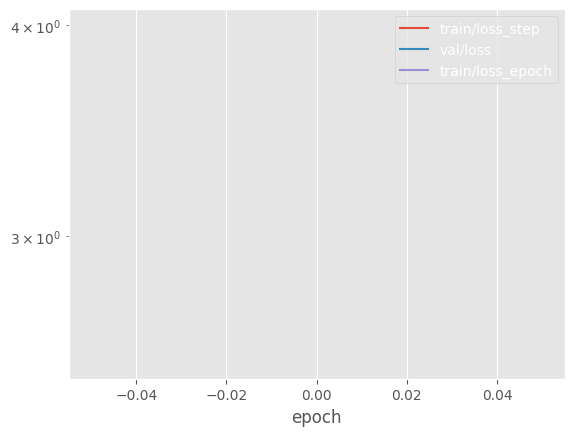

In [23]:
df_hist = read_metrics_csv(trainer1.logger.experiment.metrics_file_path).ffill().bfill()
for key in ["loss"]:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)


In [24]:
df_hist


,step,train/loss_step,val/n,val/loss,train/loss_epoch,train/n
epoch,,,,,,
0,8.333333,3.995688,75.0,2.526711,3.423802,150.0


## Generate


In [25]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


In [26]:
# get a row
bi = cfg.intervention_fit_examples + 2
inputs = ds_tokens.with_format("torch")[bi]

# tokenize if needed
if "input_ids" not in inputs:
    model_inputs = self.tokenizer(
        inputs["question"],
        return_tensors=True,
        return_attention_mask=True,
        add_special_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=cfg.max_length,
        **tokenize_kwargs,
    )
    model_inputs = model_inputs.to(device)
    inputs = {**inputs, **model_inputs}

inputs.keys()


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'])

In [27]:
from IPython.display import display, HTML

# generate
# https://huggingface.co/docs/transformers/v4.34.1/en/main_classes/text_generation#transformers.GenerationConfig


@torch.no_grad()
def gen(model):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :]
        .to(model.device)
        .to(model.dtype),
        use_cache=False,
        max_new_tokens=20,
        min_new_tokens=20,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    old = tokenizer.decode(
        s[0, :input_l], clean_up_tokenization_spaces=False, skip_special_tokens=False
    )
    new = tokenizer.decode(
        s[0, input_l:], clean_up_tokenization_spaces=False, skip_special_tokens=False
    )
    display(HTML(f"<pre>{old}</pre><b><pre>{new}</pre></b>"))


In [28]:
# with model.disable_adapters():
with model.disable_adapter():
    gen(model)


In [29]:
# model.enable_adapters()
gen(model)


# Test

In [30]:
N = sum(cfg.max_examples)
ds_name = "imdb"
ds_tokens = load_preproc_dataset(
    ds_name,
    tokenizer,
    N=N // 4,
    seed=cfg.seed,
    num_shots=cfg.num_shots,
    max_length=cfg.max_length,
    prompt_format=cfg.prompt_format,
).with_format("torch")


2023-12-19 07:48:39.113 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:364 - median token length: 615.0 for imdb. max_length=777
2023-12-19T07:48:39.113447+0800 INFO median token length: 615.0 for imdb. max_length=777
2023-12-19 07:48:39.114 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:368 - truncation rate: 20.35% on imdb
2023-12-19T07:48:39.114468+0800 INFO truncation rate: 20.35% on imdb
Filter: 100%|██████████| 180/180 [00:00<00:00, 2591.02 examples/s]
2023-12-19 07:48:39.189 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:377 - num_rows (after filtering out truncated rows) 226=>180
2023-12-19T07:48:39.189902+0800 INFO num_rows (after filtering out truncated rows) 226=>180


In [31]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size * 3)
dl_train2 = dm.train_dataloader()
dl_val2 = dm.val_dataloader()
dl_test2 = dm.test_dataloader()


In [32]:
dl_oos2 = DataLoader(
    ds_tokens, batch_size=cfg.batch_size * 3, drop_last=False, shuffle=False
)


In [33]:
def get_acc_subset(df, query, verbose=True):
    if query:
        df = df.query(query)
    acc = (df["probe_pred"] == df["y"]).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits["test"]
    df_test = dm.df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred > 0.0

    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits["val"]
        df_val = dm.df.iloc[splits[0] : splits[1]].copy()
        df_val["probe_pred"] = y_val_pred > 0.0

        df_test = pd.concat([df_val, df_test])

    if verbose:
        print("probe results on subsets of the data")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "llm_ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "llm_ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & llm_ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & llm_ans!=label_instructed", verbose=False
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["instructed_to_lie==False", "instructed_to_lie==True"],
        columns=["llm_ans==label_instructed", "llm_ans!=label_instructed"],
    )
    d1 = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    d1.index.name = "instructed to"
    d1.columns.name = "llm gave"
    print("probe accuracy for quadrants")
    display(d1.round(2))

    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)


In [34]:
import re


def transform_dl_k(k: str) -> str:
    p = re.match(r"test\/(.+)\/dataloader_idx_\d", k)
    return p.group(1) if p else k


def rename(rs, ks=["train", "val", "test"]):
    rs = {
        ks[i]: {transform_dl_k(k): v for k, v in rs[i].items()} for i in range(len(ks))
    }
    return rs


In [35]:
model.device


device(type='cuda', index=0)

In [36]:
rs = trainer1.test(
    net,
    dataloaders=[
        # dl_train2, dl_val2,
        dl_test2,
        dl_oos2,
    ],
)
rs = rename(rs, ["train", "val", "test", "oos"])
rs[0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 1: 100%|██████████| 13/13 [00:20<00:00,  0.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │     4.760440826416016     │    4.4102888107299805     │
│          test/n           │           19.0            │           75.0            │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

IndexError: list index out of range

# Predict

TODO


In [ ]:
rv = trainer1.predict(net, dataloaders=dl_val)
y_val_pred = np.concatenate(rv)


In [ ]:
rs


In [ ]:
model.device


In [ ]:
testval_metrics = calc_metrics(dm, trainer1, net, use_val=True)

# rs['test'] = {**rs['test'], **test_metrics}
rs["test"]["acc_lie_lie"] = testval_metrics["acc_lie_lie"]
rs["testval_metrics"] = rs["test"]
